<a href="https://colab.research.google.com/github/hojoooon/PDM16/blob/main/py-tensorflow/DL2-CNN/dl2_05_mnist_CNN_Daug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN model of mnist dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    - > 2차원 필터로 영상을 대표하는 특징을 추출
    * FCN : 1차원 완전연결신경망
    - > Conv2D에서 추출된 대표 특징들을 이용하여 FCN으로 최종 학습 완료
    * **Data augmentation(데이터 보강)**

***
- ## Traget: **Find the best model**
***

![mnist_NN_2_layers](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

(source: https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

print(tf.__version__)

2.7.0


In [2]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [3]:
from keras.datasets import mnist

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

11501568/11490434 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [4]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [5]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((60000,), (60000, 10))

### Display numbers
- one random number
- 10 representative numbers

12492


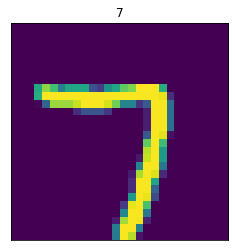

In [6]:
# Code here!
# display one random image from the training set:
class_names = ["0","1","2","3","4","5","6","7","8","9"]

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

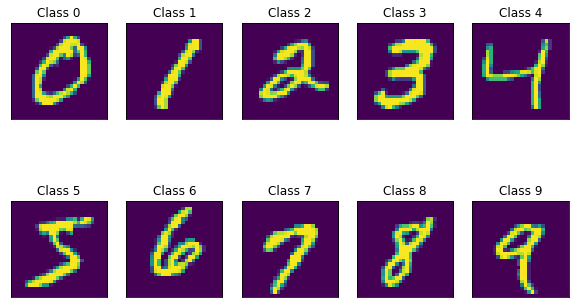

In [7]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

## data augmentation(데이터 보강)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # 1을 15도 기울임
    width_shift_range=0.1,  # 1을 좌측으로 shift_range 이동
    height_shift_range=0.1, # 1을 위쪽으로 //
    horizontal_flip=False,  # 좌우를 반전
    )
datagen.fit(X_train)

(9, 28, 28, 1) (9, 10)


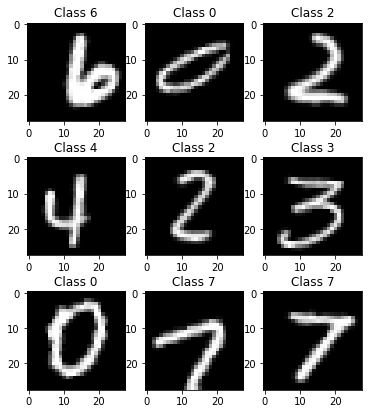

In [9]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    print(X_batch.shape, y_batch.shape)
    # create a grid of 3x3 images
    plt.figure(figsize=(6,7))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.title("Class %d" % (np.argmax(y_batch[i])))
        # show the plot
    plt.show()
    break


In [10]:
BATCH_SIZE=50
itr = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
itr.next()[0].shape,itr.next()[1].shape
#(50, 28, 28, 1) 50*28*28, 컬러파일 1

((50, 28, 28, 1), (50, 10))

In [11]:
# itr.next()[0][0].shape

In [12]:
images = np.squeeze(itr.next()[0],3)

In [13]:
labels = np.argmax(itr.next()[1],1)
labels

array([2, 9, 0, 6, 7, 8, 1, 7, 5, 1, 5, 1, 0, 1, 9, 1, 6, 3, 2, 2, 0, 5,
       5, 2, 3, 2, 9, 0, 6, 9, 7, 2, 9, 4, 4, 8, 3, 1, 4, 2, 7, 0, 6, 7,
       0, 8, 6, 2, 4, 5])

(50, 28, 28, 1) (50, 10)


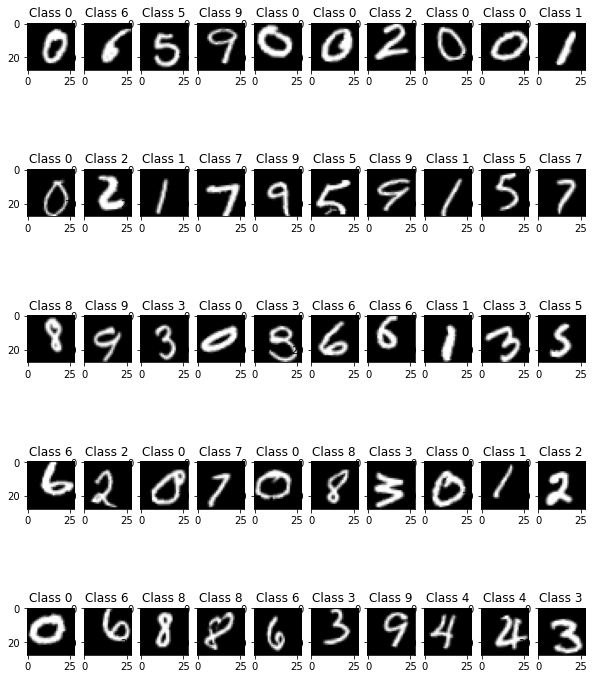

In [14]:
BATCH_SIZE = 50
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=BATCH_SIZE):
    print(X_batch.shape, y_batch.shape)
    # create a grid of 5x10 images
    plt.figure(figsize=(10,13))
    for i in range(BATCH_SIZE):
        plt.subplot(5,10,i+1)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.title("Class %d" % (np.argmax(y_batch[i])))
        # show the plot
    plt.show()
    break


### wrong match between images and classes by iteration

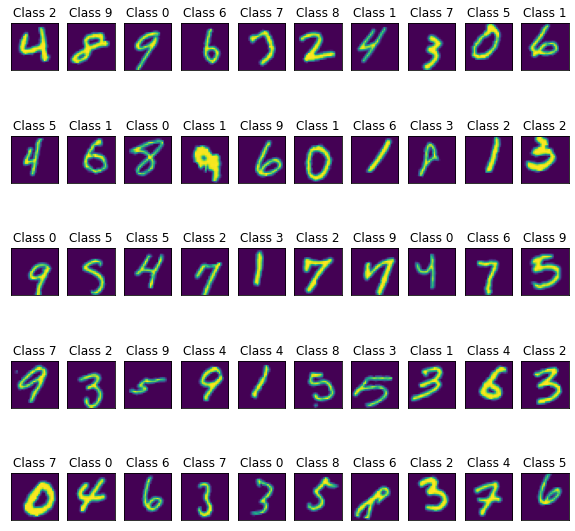

In [15]:
#그림과 레이블이 일치 하지 않음 위와 같은 방법을 사용하여 처리 하여야 함
fig = plt.figure(figsize=(10,10))
for i in range(BATCH_SIZE):
    plt.subplot(5, 10, i+1)
    # num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(images[i]) #, cmap='gray') 
    plt.title("Class %d" % (labels[i]))
    plt.xticks([])
    plt.yticks([])  

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers

In [17]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [18]:
# 모델 구성
num_classes = 10
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dense(num_classes, activation='softmax'))

In [19]:
opt_rms = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
cp_callback = callbacks.ModelCheckpoint(filepath="./mnist_Daug_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [21]:
model.compile(loss='categorical_crossentropy',
        optimizer='adam', #opt_rms,
        metrics=['accuracy'])

In [22]:
# hist = model.fit(X_train, y_train, epochs = 500 , batch_size =batch_size, 
#          callbacks=[cp_callback, es_callback], 
#          validation_data=(X_test,y_test))

epochs = 500
hist = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), # data augmentation로변형된 데이터 50개를 이미지데이터로 변환하여 훈련
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[cp_callback, es_callback], 
                 validation_data=(X_test,y_test))

Epoch 1/500
1200/1200 [==============================] - 55s 35ms/step - loss: 0.2956 - accuracy: 0.9207 - val_loss: 0.0843 - val_accuracy: 0.9870
Epoch 2/500
1200/1200 [==============================] - 41s 34ms/step - loss: 0.1366 - accuracy: 0.9714 - val_loss: 0.1040 - val_accuracy: 0.9843
Epoch 3/500
1200/1200 [==============================] - 41s 34ms/step - loss: 0.1180 - accuracy: 0.9795 - val_loss: 0.0827 - val_accuracy: 0.9901
Epoch 4/500
1200/1200 [==============================] - 41s 34ms/step - loss: 0.1181 - accuracy: 0.9800 - val_loss: 0.1137 - val_accuracy: 0.9825
Epoch 5/500
1200/1200 [==============================] - 41s 34ms/step - loss: 0.1118 - accuracy: 0.9826 - val_loss: 0.0850 - val_accuracy: 0.9919
Epoch 6/500
1200/1200 [==============================] - 41s 34ms/step - loss: 0.1125 - accuracy: 0.9832 - val_loss: 0.0863 - val_accuracy: 0.9917
Epoch 7/500
1200/1200 [==============================] - 41s 34ms/step - loss: 0.1127 - accuracy: 0.9836 - val_loss: 0

In [23]:
model.evaluate(X_test, y_test, batch_size = BATCH_SIZE)

200/200 [==============================] - 2s 10ms/step - loss: 0.0845 - accuracy: 0.9913


[0.08447548747062683, 0.9912999868392944]

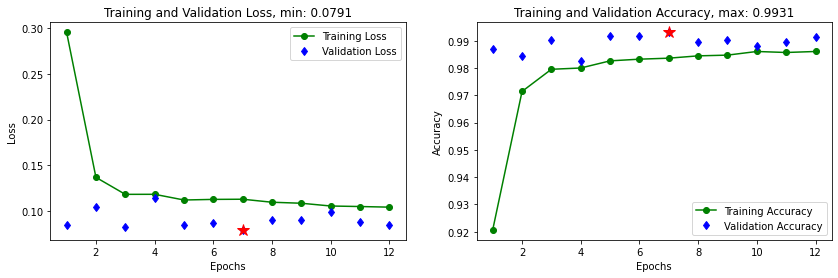

In [24]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Best model
- mnist_Daug_best_weights.002-0.9903.hdf5

---

## **CNN2 + FCN2**

In [25]:
# Random number seed
np.random.seed(1234)
tf.random.set_seed(1234)

In [26]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [27]:
c2f2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [28]:
cp_callback = callbacks.ModelCheckpoint(filepath="./mnist_c2f2_Daug_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)    # patience=10,20,50

In [29]:
# hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =32, 
#          callbacks=[cp_callback, es_callback], 
#          validation_data=(X_test,y_test))

epochs = 500
hist = c2f2.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), # BATCH_SIZE = 50
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[cp_callback, es_callback], 
                 validation_data=(X_test,y_test))    

Epoch 1/500
1200/1200 [==============================] - 31s 26ms/step - loss: 0.3121 - accuracy: 0.9007 - val_loss: 0.0467 - val_accuracy: 0.9841
Epoch 2/500
1200/1200 [==============================] - 30s 25ms/step - loss: 0.1215 - accuracy: 0.9626 - val_loss: 0.0312 - val_accuracy: 0.9895
Epoch 3/500
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0939 - accuracy: 0.9711 - val_loss: 0.0284 - val_accuracy: 0.9905
Epoch 4/500
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0801 - accuracy: 0.9753 - val_loss: 0.0253 - val_accuracy: 0.9912
Epoch 5/500
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0706 - accuracy: 0.9782 - val_loss: 0.0226 - val_accuracy: 0.9926
Epoch 6/500
1200/1200 [==============================] - 29s 24ms/step - loss: 0.0619 - accuracy: 0.9810 - val_loss: 0.0231 - val_accuracy: 0.9923
Epoch 7/500
1200/1200 [==============================] - 30s 25ms/step - loss: 0.0576 - accuracy: 0.9823 - val_loss: 0

In [30]:
c2f2.evaluate(X_test, y_test, batch_size = BATCH_SIZE)

200/200 [==============================] - 1s 5ms/step - loss: 0.0216 - accuracy: 0.9917


[0.021649083122611046, 0.9916999936103821]

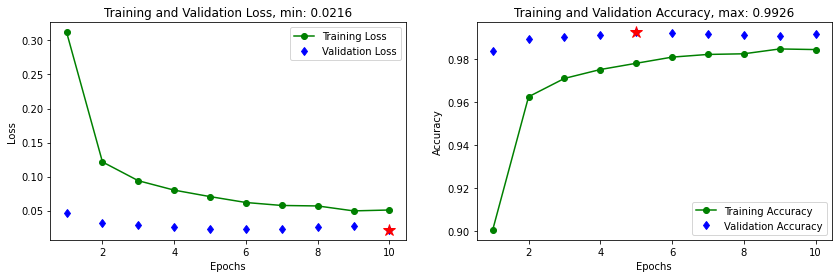

In [31]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 모형의 저장

- 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

### Best model
- mnist_Daug_best_weights.002-0.9903.hdf5
- mnist_c2f2_Daug_best_weights.015-0.9949.hdf5

In [33]:
from keras.models import load_model

model_c2f2_best = load_model('mnist_c2f2_Daug_best_weights.005-0.9926.hdf5')
model_c2f2_best.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 1s 5ms/step - loss: 0.0226 - accuracy: 0.9926


[0.022569965571165085, 0.9926000237464905]

---

In [34]:
from sklearn.metrics import confusion_matrix

predictions = model_c2f2_best.predict(X_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test0, predictions0)


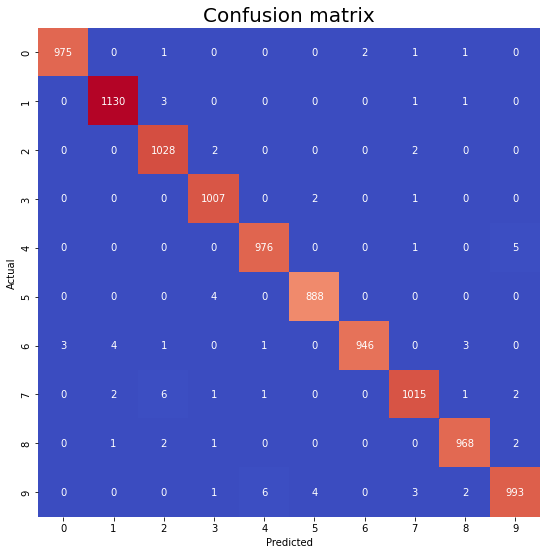

In [35]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()

---